Link of web application:  https://stremlitappplantvillage-mtwhhjqrvveehxsdtwmv8k.streamlit.app/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers, Sequential, losses

In [2]:
# Initialize some Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [3]:
# Create the image dataset from the virtual folder
dataset_color = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage_color",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
)
# Display class names
class_names = dataset_color.class_names
print("Class Names:", class_names)

Found 20638 files belonging to 15 classes.
Class Names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [4]:
for image_batch, labels_batch in dataset_color.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 7 12  2  7 11 14  0  7  6  2 12 11 10  5 14  0  7  8 10  7  6  2  7  0
 14 12 12 12 10  0 10  7]


In [5]:
len(dataset_color)

645

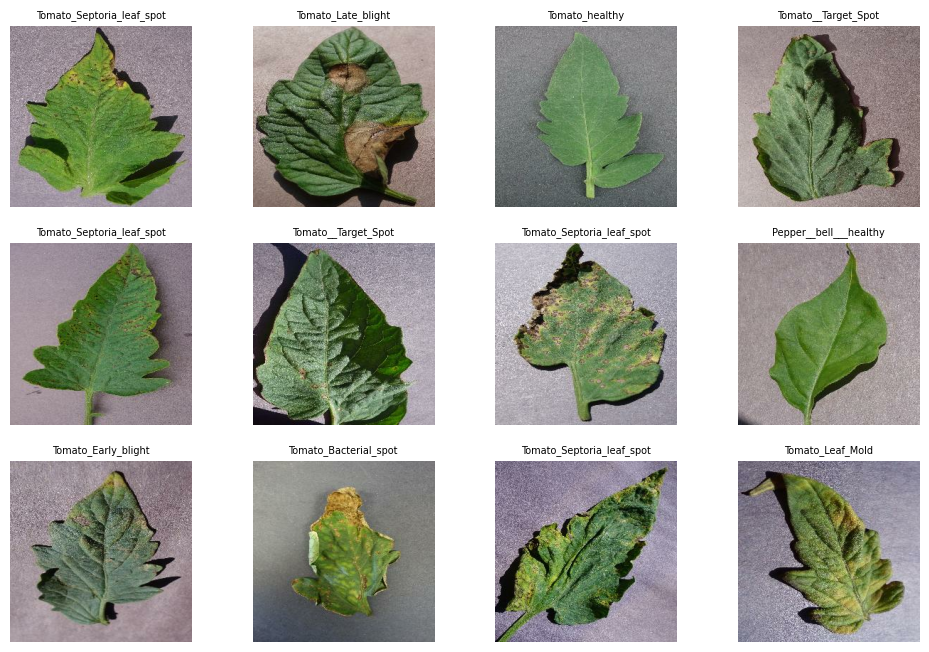

In [6]:
# Data Visualization
plt.figure(figsize=(12,8))
for image_batch, label_batch in dataset_color.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i].numpy()], fontsize = 7)
        plt.axis('off')

In [7]:
def get_dataset_partitions(dataset, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):
    # Length of Dataset
    dataset_size = len(dataset)
    
    # Shuffling
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    # Splitting
    train_size = int(dataset_size * train_size)
    val_size = int(dataset_size * val_size)
    
    # Training
    train_dataset = dataset.take(train_size)
    
    # Validation and Testing
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions(dataset_color)

In [9]:
print(f"Length of Training Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")
print(f"Length of Testing Dataset: {len(test_dataset)}")
print(f"Is the length of the whole dataset equal to the length of the sum of the splits?", 
     (len(dataset_color) == (len(train_dataset) + len(val_dataset) + len(test_dataset))))

Length of Training Dataset: 516
Length of Validation Dataset: 64
Length of Testing Dataset: 65
Is the length of the whole dataset equal to the length of the sum of the splits? True


In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Initialize some Constants
N_CLASSES = len(class_names)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [12]:
# Définir les transformations de redimensionnement et de remise à l'échelle
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Redimensionner les images à la taille spécifiée
    layers.Rescaling(1./255)  # Remettre à l'échelle les valeurs des pixels à [0, 1]
])

# Définir les transformations d'augmentation des données
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),  # Retourner aléatoirement les images horizontalement et verticalement
    layers.RandomRotation(0.2)  # Faire tourner aléatoirement les images jusqu'à 20%
])

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Dense, Flatten, concatenate

# Fonction pour créer un bloc Inception
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

input_shape = (256, 256, 3)  # Définissez votre forme d'entrée
 # Définissez le nombre de classes pour votre tâche

input_layer = Input(shape=input_shape)
x = resize_rescale(input_layer)  # Redimensionnement et mise à l'échelle
x = data_augmentation(x)  # Augmentation de données

# Initial Conv and MaxPooling
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)

# Second Conv and MaxPooling
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.BatchNormalization()(x)

# Inception blocks
x = inception_module(x, 64, 96, 128, 16, 32, 32)  # Inception (3a)
x = inception_module(x, 128, 128, 192, 32, 96, 64)  # Inception (3b)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 192, 96, 208, 16, 48, 64)  # Inception (4a)
x = inception_module(x, 160, 112, 224, 24, 64, 64)  # Inception (4b)
x = inception_module(x, 128, 128, 256, 24, 64, 64)  # Inception (4c)
x = inception_module(x, 112, 144, 288, 32, 64, 64)  # Inception (4d)
x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception (4e)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, 256, 160, 320, 32, 128, 128)  # Inception (5a)
x = inception_module(x, 384, 192, 384, 48, 128, 128)  # Inception (5b)

# Final layers
x = AveragePooling2D((7, 7), strides=(1, 1))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output_layer = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 256, 256,  │          0 │ sequential[0][0]  │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ sequential_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    110,784 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,528 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      3,088 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     12,352 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_2[0][0], 

 Total params: 6,031,871 (23.01 MB)

 Trainable params: 6,031,359 (23.01 MB)

 Non-trainable params: 512 (2.00 KB)

In [14]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# Define learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.005
    if epoch > 30/3:
        return initial_lr * 0.1
    return initial_lr

# Define SGD optimizer
sgd = SGD(learning_rate=0.005, momentum=0.9)

# Compile the model
model.compile(
    optimizer=sgd,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Train the model with the learning rate schedule
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset,
    callbacks=[LearningRateScheduler(lr_schedule)]
)

Epoch 1/15


516/516 ━━━━━━━━━━━━━━━━━━━━ 2352s 4s/step - accuracy: 0.2996 - loss: 2.1052 - val_accuracy: 0.2222 - val_loss: 3.6637 - learning_rate: 0.0050
Epoch 2/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 2254s 4s/step - accuracy: 0.6779 - loss: 0.9659 - val_accuracy: 0.3003 - val_loss: 4.7354 - learning_rate: 0.0050
Epoch 3/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 3129s 6s/step - accuracy: 0.7907 - loss: 0.6091 - val_accuracy: 0.7832 - val_loss: 0.6109 - learning_rate: 0.0050
Epoch 4/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 4228s 8s/step - accuracy: 0.8617 - loss: 0.4054 - val_accuracy: 0.8140 - val_loss: 0.5897 - learning_rate: 0.0050
Epoch 5/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 4284s 8s/step - accuracy: 0.8980 - loss: 0.2981 - val_accuracy: 0.9189 - val_loss: 0.2124 - learning_rate: 0.0050
Epoch 6/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 5212s 10s/step - accuracy: 0.9177 - loss: 0.2520 - val_accuracy: 0.7236 - val_loss: 0.8805 - learning_rate: 0.0050
Epoch 7/15
516/516 ━━━━━━━━━━━━━━━━━━━━ 5250s 10s/step - accuracy: 0.9299 - loss: 0.20

In [16]:
score = model.evaluate(test_dataset)

65/65 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9877 - loss: 0.0348


In [17]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 516}

In [18]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

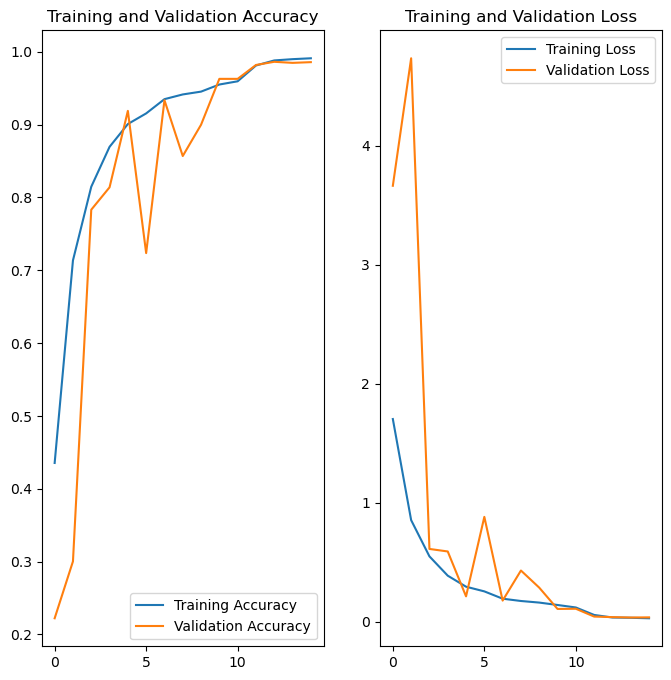

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
model.save('models/my_model.keras')

In [56]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf

# Assuming predict function and class_names are defined
def predict(model, image):
    # Predict the class probabilities
    predictions = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100
    return predicted_class, confidence

# Collect all predictions and actual labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    for i in range(len(images)):
        image = images[i].numpy().astype("uint8")
        actual_class = labels[i].numpy()
        predicted_class, _ = predict(model, image)
        
        y_true.append(actual_class)
        y_pred.append(predicted_class)

class_names = dataset_color.class_names

# Print classification report
y_true = np.array(y_true)
y_pred = np.array(y_pred)

L=classification_report(y_true, y_pred, target_names=class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━

In [78]:
print("Classification Report:\n----------------------\n", L)

Classification Report:
----------------------
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      1.00       105
                     Pepper__bell___healthy       0.99      1.00      1.00       166
                      Potato___Early_blight       1.00      1.00      1.00       103
                       Potato___Late_blight       0.99      0.99      0.99        95
                           Potato___healthy       1.00      0.94      0.97        17
                      Tomato_Bacterial_spot       0.99      1.00      0.99       216
                        Tomato_Early_blight       0.95      0.98      0.97       108
                         Tomato_Late_blight       0.99      0.97      0.98       175
                           Tomato_Leaf_Mold       1.00      0.99      1.00       104
                  Tomato_Septoria_leaf_spot       0.98      0.99      0.99       180
Tomato_Spider_mit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


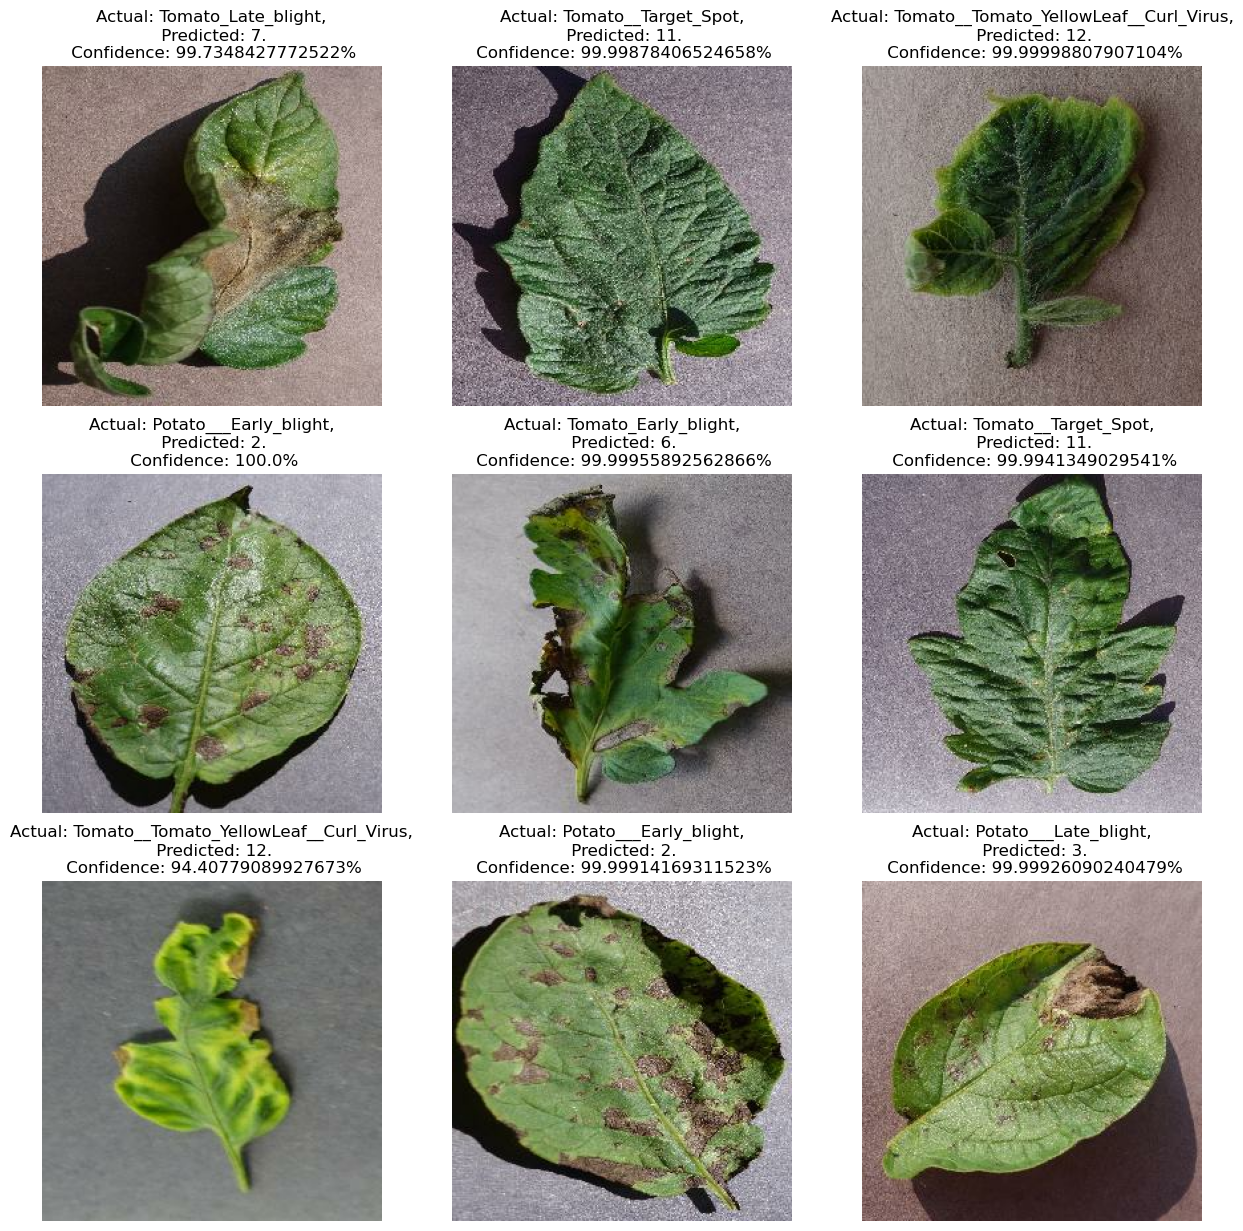

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class_test, confidence = predict(model, images[i].numpy())
        actual_class_test = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class_test},\n Predicted: {predicted_class_test}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model('models/my_model.keras')

In [4]:
# Obtenir les poids
weights = loaded_model.get_weights()

# Afficher les poids
for layer_num, layer_weights in enumerate(weights):
    print(f"Poids de la couche {layer_num}: {layer_weights}")

Poids de la couche 0: [[[[-5.36993295e-02 -2.21953094e-02 -2.56600268e-02 ...  6.03884123e-02
     1.22860512e-02  3.09504624e-02]
   [-3.41938511e-02 -5.50282896e-02 -3.82302366e-02 ... -4.46673781e-02
     6.15244906e-04  1.86140649e-02]
   [-3.62670124e-02 -4.42289375e-02  3.31508406e-02 ...  6.55794889e-02
    -3.39293331e-02 -3.39099914e-02]]

  [[-9.19818692e-03 -2.44476814e-02  1.20436605e-02 ... -2.35778280e-02
    -1.60234161e-02  3.74710076e-02]
   [-2.90584303e-02 -1.24257058e-02  2.79469676e-02 ... -7.01930095e-03
    -7.17439950e-02  6.36525871e-03]
   [-2.87839808e-02 -4.82167630e-03 -5.73488092e-03 ...  4.97693196e-02
     1.27315354e-02 -2.56045107e-02]]

  [[-1.37475813e-02 -9.11760982e-03 -2.03126892e-02 ... -2.54880432e-02
    -5.93709648e-02  3.36466953e-02]
   [-8.95778537e-02  3.43419462e-02  9.91743896e-03 ... -6.29298612e-02
    -4.13419046e-02  1.47019757e-03]
   [ 7.35972950e-04  2.36276202e-02 -1.73704531e-02 ...  2.22493615e-02
    -1.10972235e-02  5.2660149

In [7]:
model_new = tf.keras.models.load_model('models/my_model.keras')

In [21]:
model_new.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 256, 256,  │          0 │ sequential[0][0]  │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ sequential_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    110,784 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     18,528 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      3,088 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     12,352 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_2[0][0], 

 Total params: 12,063,232 (46.02 MB)

 Trainable params: 6,031,359 (23.01 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 6,031,361 (23.01 MB)